# Section 0. Installing and Importing Packages

In [119]:
!pip install requests beautifulsoup4 lxml
!pip install IMDbPY
!pip install selenium
!pip install webdriver-manager
!pip install matplotlib
!pip install pandas
!pip install scikit-learn
!pip install seaborn
!pip install fuzzywuzzy
!pip install yellowbrick


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [1]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import re
from imdb import IMDb
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
import time
import os
import matplotlib.pyplot as plt
import html
import concurrent.futures
import numpy as np
import seaborn as sns
import glob
import shutil
from datetime import datetime

# for model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# Section 1: Extracting/Scraping Oscar Information from IMDB 

Using `BeautifulSoup` Python library, the following scrapes data from [IMDB](https://www.imdb.com) for the Oscar nominated and winners. This is in preparation to finding the name of the Oscar nominated or winner movies to find their genre and script for comparison. The next step would be comparing these top rated  movies with a random sample (same size) of differently rated movies of the same genre.

## Section 1.1: Functions

### **Function 1:** Extract Oscar Nominated movie names for a given range defined by the user

In [121]:
def fetch_imdb_data(start_year, end_year):
    base_url = 'https://www.imdb.com/event/ev0000003/{}/1/?ref_=fea_acd_c_csegosc_ft_oscars{}_cta'
    output_dir = 'extracted_data'
    combined_data = []
    files_to_delete = []

    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    for year in range(start_year, end_year + 1):
        url = base_url.format(year, year % 100)
        print(f"Fetching data from URL: {url}")
        response = requests.get(url)
        
        if response.status_code == 200:
            html_content = response.text
            
            # Parse HTML content using BeautifulSoup
            soup = BeautifulSoup(html_content, 'lxml')
            soup_str = str(soup)
            
            # Write the HTML content to a text file
            html_filename = os.path.join(output_dir, f'page_content_{year}.txt')
            with open(html_filename, 'w', encoding='utf-8') as file:
                file.write(soup_str)
            
            files_to_delete.append(html_filename)  # Keep track of HTML files to delete later
            print(f"HTML content has been successfully written to '{html_filename}'.")

            # Use regular expression to find the JSON data within the JavaScript snippet
            pattern = re.compile(r'IMDbReactWidgets\.NomineesWidget\.push\(\[\'center-3-react\',(.*?)\]\);', re.DOTALL)
            match = pattern.search(html_content)

            if match:
                json_data_str = match.group(1).strip().rstrip(';')
                try:
                    # Parse the JSON data
                    data = json.loads(json_data_str)
                    
                    # Extract "Best Picture" information
                    best_picture_data = extract_best_picture(data)
                    
                    # Add year to each entry and accumulate data
                    if isinstance(best_picture_data, list):
                        for entry in best_picture_data:
                            entry['Year'] = year
                        combined_data.extend(best_picture_data)
                    elif isinstance(best_picture_data, dict):
                        best_picture_data['Year'] = year
                        combined_data.append(best_picture_data)
                    
                    json_filename = os.path.join(output_dir, f'best_picture_{year}.json')
                    with open(json_filename, 'w', encoding='utf-8') as json_file:
                        json.dump(best_picture_data, json_file, indent=4)
                    
                    files_to_delete.append(json_filename)  # Keep track of JSON files to delete later
                    
                    if best_picture_data:
                        print(f"Best Picture data for year {year} has been successfully extracted and saved to '{json_filename}'.")
                    else:
                        print(f"No Best Picture data found for year {year}.")
                
                except json.JSONDecodeError as e:
                    print(f"Error decoding JSON for year {year}:", e)
            else:
                print(f"No matching data found for year: {year}")
        else:
            print(f"Failed to fetch data for year: {year}, Status Code: {response.status_code}")

    # Save combined data to a single JSON file
    combined_filename = os.path.join(output_dir, f'best_picture_data_year_{start_year}_to_{end_year}.json')
    with open(combined_filename, 'w', encoding='utf-8') as outfile:
        json.dump(combined_data, outfile, indent=4)
    
    print(f"All Best Picture data from {start_year} to {end_year} has been combined and saved to '{combined_filename}'.")

    # Delete individual HTML and JSON files
    for file in files_to_delete:
        try:
            os.remove(file)
            print(f"Deleted: {file}")
        except OSError as e:
            print(f"Error deleting {file}: {e}")

    print("All individual files have been deleted.")


In [122]:
fetch_imdb_data(1973, 2023)  # Getting data for the past 50 years - Replace with desired range

Fetching data from URL: https://www.imdb.com/event/ev0000003/1973/1/?ref_=fea_acd_c_csegosc_ft_oscars73_cta
HTML content has been successfully written to 'extracted_data/page_content_1973.txt'.
Best Picture data for year 1973 has been successfully extracted and saved to 'extracted_data/best_picture_1973.json'.
Fetching data from URL: https://www.imdb.com/event/ev0000003/1974/1/?ref_=fea_acd_c_csegosc_ft_oscars74_cta
HTML content has been successfully written to 'extracted_data/page_content_1974.txt'.
Best Picture data for year 1974 has been successfully extracted and saved to 'extracted_data/best_picture_1974.json'.
Fetching data from URL: https://www.imdb.com/event/ev0000003/1975/1/?ref_=fea_acd_c_csegosc_ft_oscars75_cta
HTML content has been successfully written to 'extracted_data/page_content_1975.txt'.
Best Picture data for year 1975 has been successfully extracted and saved to 'extracted_data/best_picture_1975.json'.
Fetching data from URL: https://www.imdb.com/event/ev0000003/197

### **Function 2:** Extracting the links based on the names of the movies outputted by Function 1 (`fetch_imdb_data`)

In [123]:
ia = IMDb()

In [14]:
def get_imdb_link(movie_title, year):
    if not movie_title or not year:  # Check for empty title or year
        return None

    # Generate potential years to check
    potential_years = [year - 2, year - 1, year]

    # Search for the movie by title
    search_results = ia.search_movie(movie_title)
    
    if not search_results:
        print(f"No search results found for title: {movie_title}")
        return None

   # print(f"Search results for '{movie_title}': {[movie['title'] for movie in search_results]}")  # Debugging line

    for movie in search_results:
        # Filter out TV Series
        if 'tv' not in movie['kind']:
            try:
                movie_details = ia.get_movie(movie.movieID)
                # Check if year is in movie details and compare
                if 'year' in movie_details:
                    movie_year = movie_details['year']
                    if movie_year in potential_years:
                        imdb_id = movie.movieID
                        return f"https://www.imdb.com/title/tt{imdb_id}/"
                    
                    # Skip printing the year mismatch message
                    continue
                
            except Exception as e:
                print(f"Error fetching details for {movie_title}: {e}")

    print(f"No valid movie found for '{movie_title}' in years {potential_years}.")
    return None


### **Function 3:** Extacting information such as "Director", "Cast" and "Ratings" given the links pulled using Function 2 (`get_imdb_link`)

In [125]:
# Define the extraction function
def extract_info(html_content):
    # Define regex patterns
    directed_by_pattern = re.compile(r'Directed by (.*?)(?:\.|$)', re.DOTALL)
    rating_value_pattern = re.compile(r'"ratingValue":(\d+\.\d+)', re.DOTALL)

    # Initialize results
    result = {
        'Director': None,
        'Rating Value': None
    }
    
    # Search for the patterns in the HTML content
    directed_by_match = directed_by_pattern.search(html_content)
    rating_value_match = rating_value_pattern.search(html_content)

    
    # Extract 'Directed by' information
    if directed_by_match:
        result['Director'] = directed_by_match.group(1).strip()
    
    # Extract 'Rating Value' information
    if rating_value_match:
        result['Rating Value'] = rating_value_match.group(1).strip()
    else: 
        rating_value_pattern = re.compile(r'"aggregateRating":\s*{[^}]*"ratingValue":\s*(\d+)', re.DOTALL)
        rating_value_match = rating_value_pattern.search(html_content)
        result['Rating Value'] = rating_value_match.group(1).strip()

    
    return result



### **Function 4:** Extacting information about best picture nominees

In [126]:
def extract_best_picture(data):
    """
    Extracts information about the Best Picture category from the JSON data.
    
    Args:
        data (dict): The JSON data parsed from the HTML content.
    
    Returns:
        dict: Extracted information about the Best Picture category.
    """
    best_picture_data = {}

    if 'nomineesWidgetModel' in data:
        nominees_widget_model = data['nomineesWidgetModel']
        event_edition_summary = nominees_widget_model['eventEditionSummary']

        if isinstance(event_edition_summary, dict):
            awards = event_edition_summary['awards']
            categories = awards[0]['categories']
            
            for category in categories:
                if category.get('categoryName') in ['Best Picture', 'Best Motion Picture of the Year']:
                    best_picture_data = [
                        {
                            'primaryNominees_name': nom.get('primaryNominees', [{}])[0].get('name') if nom.get('primaryNominees') else None,
                            'isWinner': nom.get('isWinner') if isinstance(nom, dict) and 'isWinner' in nom else None
                        }
                        for nom in category.get('nominations', [])
                    ]
                    
                    if len(best_picture_data) == 1:
                        best_picture_data = best_picture_data[0]

                    break

    return best_picture_data

### **Function 5.** Downloading Scripts

In [ ]:
def fetch_script_link(movie_title, year, driver):
    """Fetch the script URL for a given movie title and years (year, year-1, year+1)."""
    for search_year in [year, year - 1, year + 1]:
        # Check IMSDB
        script_content = fetch_from_imsdb(movie_title, driver)
        if script_content:
            return script_content

        # Check ScriptSlug
        script_content = fetch_from_scriptslug(movie_title, search_year)
        if script_content:
            return script_content
        
        # Check SimplyScripts
        script_content = fetch_from_simplyscripts(movie_title, search_year)
        if script_content:
            return script_content

    return None

def fetch_from_imsdb(movie_title, driver):
    """Fetch the script from imsdb.com."""
    formatted_title = movie_title.replace(' ', '-').replace('_', '-')
    search_url = f"https://imsdb.com/scripts/{formatted_title}.html"
    
    try:
        driver.get(search_url)
        time.sleep(5)

        try:
            script_element = driver.find_element(By.XPATH, "//pre")
            return script_element.text
        except:
            return None

    except Exception:
        return None

def fetch_from_scriptslug(movie_title, year):
    """Fetch the script from scriptslug.com."""
    formatted_title = movie_title.lower().replace(' ', '-').replace('_', '-')
    search_url = f"https://assets.scriptslug.com/live/pdf/scripts/{formatted_title}-{year}.pdf"
    
    response = requests.get(search_url)
    if response.status_code == 200:
        return response.content
    else:
        return None

def fetch_from_simplyscripts(movie_title, year):
    """Fetch the script from simplyscripts.com."""
    formatted_title = movie_title.replace(' ', '-').lower()
    search_url = f"https://www.simplyscripts.com/scripts/{formatted_title}-{year}.html"
    
    try:
        response = requests.get(search_url)
        if response.status_code == 200:
            return response.text
        else:
            return None
    except Exception:
        return None

def save_script(script_name, script_content):
    """Save the script content to a local file."""
    script_name = script_name.replace('/', '_').replace(' ', '_').replace('%20', '_').replace('-', '_')
    file_path = os.path.join('Scripts', f'{script_name}.txt')
    
    with open(file_path, 'wb' if isinstance(script_content, bytes) else 'w', encoding='utf-8' if isinstance(script_content, str) else None) as file:
        file.write(script_content)

def main(df, movie_column, year_column):
    """Find and download the scripts for a list of movie titles and years from a DataFrame."""
    options = Options()
    options.headless = False
    
    with webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options) as driver:
        movie_titles = df[movie_column].tolist()
        years = df[year_column].tolist()
        no_scripts = []  # List to collect movies with no scripts found
        
        for movie_title, year in zip(movie_titles, years):
            script_content = fetch_script_link(movie_title, year, driver)
            if script_content:
                save_script(movie_title, script_content)
            else:
                no_scripts.append(f"{movie_title} ({year})")
        
    # Save the list of movies with no scripts to a file
    with open('no_scripts_found.txt', 'w') as f:
        for entry in no_scripts:
            f.write(f"{entry}\n")




In [127]:
df = pd.read_json('extracted_data/best_picture_data_year_1973_to_2023.json')

In [128]:
df.head()

,primaryNominees_name,isWinner,Year
0,The Godfather,True,1973
1,Cabaret,False,1973
2,Deliverance,False,1973
3,Sounder,False,1973
4,The Emigrants,False,1973


In [129]:
df.shape

(311, 3)

In [130]:
df.info

<bound method DataFrame.info of     primaryNominees_name  isWinner  Year
0          The Godfather      True  1973
1                Cabaret     False  1973
2            Deliverance     False  1973
3                Sounder     False  1973
4          The Emigrants     False  1973
..                   ...       ...   ...
306        The Fabelmans     False  2023
307    Top Gun: Maverick     False  2023
308  Triangle of Sadness     False  2023
309                  Tár     False  2023
310        Women Talking     False  2023

[311 rows x 3 columns]>

In [131]:
df.isna().sum()

primaryNominees_name    0
isWinner                0
Year                    0
dtype: int64

In [132]:
movie_names_year = {}

# Populate the dictionary
for index, row in df.iterrows():
    movie_names_year[row['primaryNominees_name']] = row['Year']

In [134]:
movie_links = {}
for title, year in movie_names_year.items():
    imdb_link = get_imdb_link(title, year)
    movie_links[title] = imdb_link  # Use title instead of item


In [137]:
len(movie_links)

311

In [139]:
for key, value in movie_links.items():
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
    response = requests.get(value, headers=headers)
    key_content = response.text
    info = extract_info(key_content)

    
    df.loc[df['primaryNominees_name'] == key, 'Director'] = info['Director']
    df.loc[df['primaryNominees_name'] == key, 'Rating'] = info['Rating Value']
   

In [140]:
df.head()

,primaryNominees_name,isWinner,Year,Director,Rating
0,The Godfather,True,1973,Francis Ford Coppola,9.2
1,Cabaret,False,1973,Bob Fosse,7.8
2,Deliverance,False,1973,John Boorman,7.7
3,Sounder,False,1973,Martin Ritt,7.5
4,The Emigrants,False,1973,Jan Troell,8


In [141]:
df.to_json('1973-2023.json', orient = 'records', indent = 4)

# 2. Visualization

In [2]:
df = pd.read_json('1973-2023.json')

In [26]:
winners_df = df[df['isWinner'] == True]

In [31]:
sorted_ratings = winners_df['Rating'].sort_values()
sorted_ratings.head()

45     7.1
130    7.1
65     7.1
150    7.2
283    7.3
Name: Rating, dtype: float64

In [37]:
sorted_winners_df = winners_df.sort_values(by='Rating', ascending=False)
sorted_winners_df.tail(20)

,primaryNominees_name,isWinner,Year,Director,Rating
205,The Artist,True,2012,Michel Hazanavicius,7.9
125,Titanic,True,1998,James Cameron,7.9
301,Everything Everywhere All at Once,True,2023,"Daniel Kwan, Daniel Scheinert",7.8
35,Kramer vs. Kramer,True,1980,Robert Benton,7.8
75,The Last Emperor,True,1988,Bernardo Bertolucci,7.7
40,Ordinary People,True,1981,Robert Redford,7.7
214,Argo,True,2013,Ben Affleck,7.7
165,Crash,True,2006,Paul Haggis,7.7
232,Birdman or (The Unexpected Virtue of Ignorance),True,2015,Alejandro G,7.7
185,The Hurt Locker,True,2010,Kathryn Bigelow,7.5


In [36]:
sorted_df = df.sort_values(by='Rating', ascending=False)
sorted_df.head()

,primaryNominees_name,isWinner,Year,Director,Rating
114,The Shawshank Redemption,False,1995,Frank Darabont,9.3
0,The Godfather,True,1973,Francis Ford Coppola,9.2
10,The Godfather Part II,True,1975,Francis Ford Coppola,9.0
105,Schindler's List,True,1994,Steven Spielberg,9.0
155,The Lord of the Rings: The Return of the King,True,2004,Peter Jackson,9.0


## 2.1. Ratings of Winners

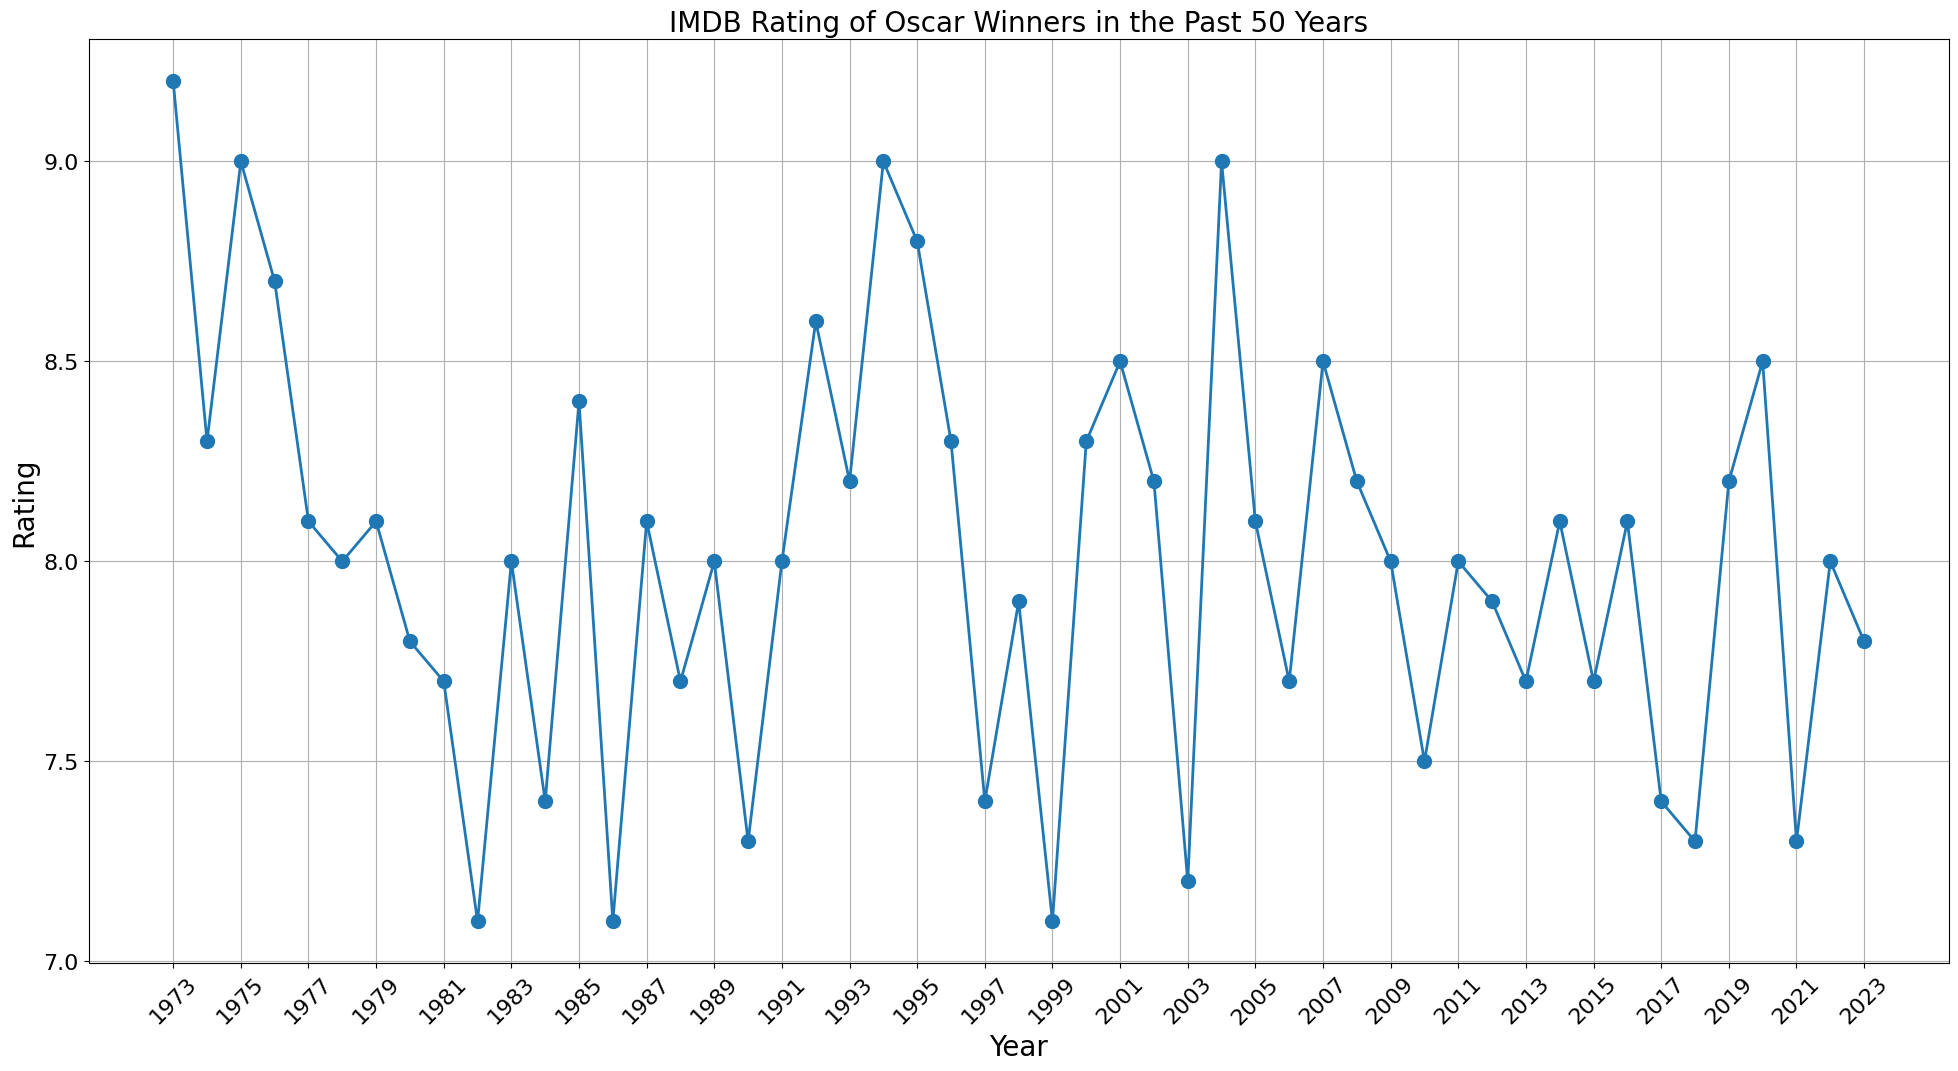

In [191]:
# Extracting the data
x = winners_df['Year']
y = winners_df['Rating']
z = winners_df['primaryNominees_name']

# Combine the data into a DataFrame and sort by Rating
plot_data = pd.DataFrame({'Year': x, 'Rating': y, 'Nominees': z})
plot_data = plot_data.sort_values(by='Rating', ascending=False)

# Create the plot with specified size
plt.figure(figsize=(24, 12))  # Set a larger figure size

# Plotting
plt.plot(x, y, marker='o', markersize=10, linewidth=2)  # Increase marker size and line width
plt.grid()

# Set axis labels with more reasonable font sizes
plt.xlabel('Year', fontsize=20)
plt.ylabel('Rating', fontsize=20)
plt.title('IMDB Rating of Oscar Winners in the Past 50 Years', fontsize = 20)

# # Display every other movie name directly on the plot
# for i in range(len(plot_data)):
#     if i % 2 == 0 and i < len(plot_data) - 1:  # Show only even-indexed movie names, limit to the plot area
#         plt.text(plot_data['Year'].iloc[i], plot_data['Rating'].iloc[i], 
#                  plot_data['Nominees'].iloc[i],
#                  ha='center', va='bottom', fontsize=12, rotation=45, bbox=dict(facecolor='black', alpha=0.7))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=16)  # Adjust font size for x-axis labels
plt.yticks(fontsize=16)  # Adjust font size for y-axis labels
plt.xticks(np.arange( min(x), max(x) + 1, 2))  # Adjust the step as needed (1 for yearly data)

# Save the plot
plt.savefig('average_ratings_by_movie.png')

# Show the plot
plt.show()


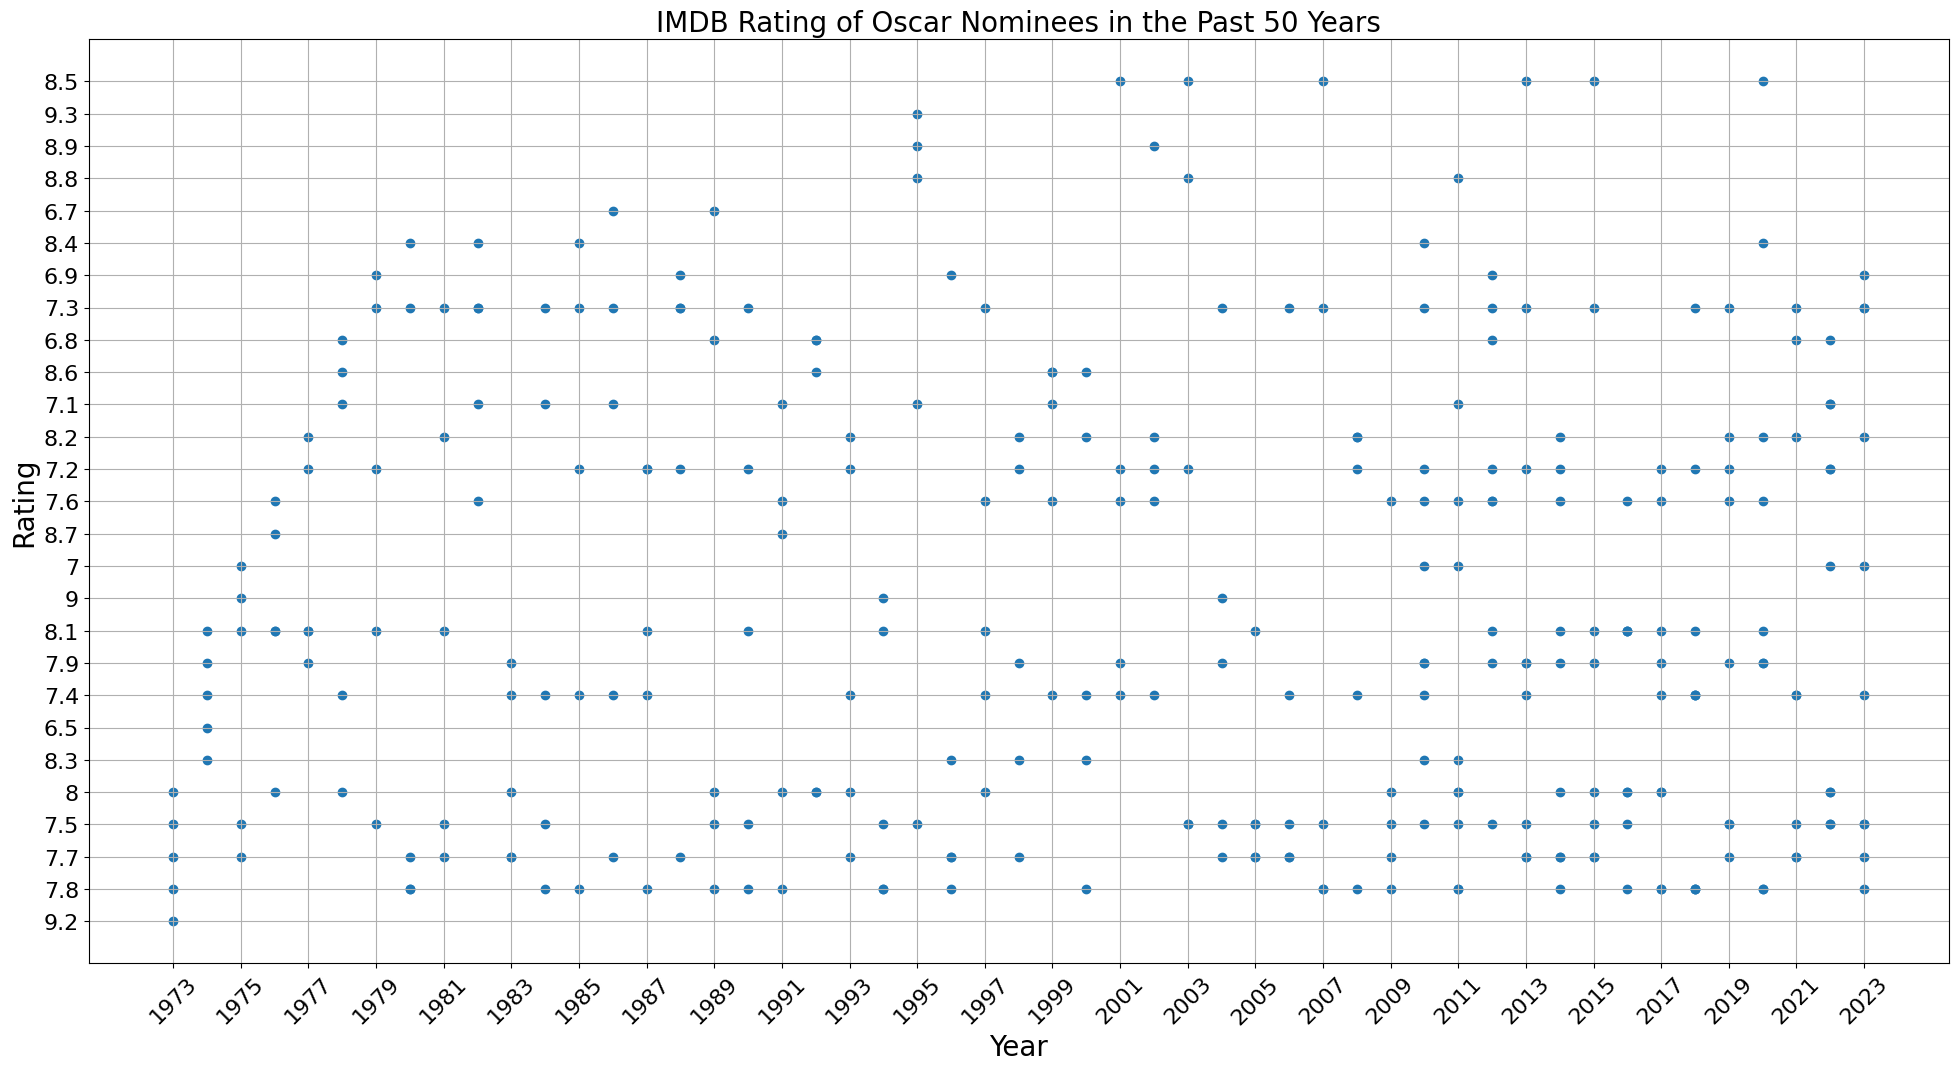

In [199]:
# Extracting the data
x = df['Year']
y = df['Rating']
z = df['primaryNominees_name']

# Combine the data into a DataFrame and sort by Rating
plot_data = pd.DataFrame({'Year': x, 'Rating': y, 'Nominees': z})
plot_data = plot_data.sort_values(by='Rating', ascending=False)

# Create the plot with specified size
plt.figure(figsize=(24, 12))  # Set a larger figure size

# Plotting
plt.scatter(x, y, marker='o')  # Increase marker size and line width
plt.grid()

# Set axis labels with more reasonable font sizes
plt.xlabel('Year', fontsize=20)
plt.ylabel('Rating', fontsize=20)
plt.title('IMDB Rating of Oscar Nominees in the Past 50 Years', fontsize = 20)

# # Display every other movie name directly on the plot
# for i in range(len(plot_data)):
#     if i % 2 == 0 and i < len(plot_data) - 1:  # Show only even-indexed movie names, limit to the plot area
#         plt.text(plot_data['Year'].iloc[i], plot_data['Rating'].iloc[i], 
#                  plot_data['Nominees'].iloc[i],
#                  ha='center', va='bottom', fontsize=12, rotation=45, bbox=dict(facecolor='black', alpha=0.7))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=16)  # Adjust font size for x-axis labels
plt.yticks(fontsize=16)  # Adjust font size for y-axis labels
plt.xticks(np.arange( min(x), max(x) + 1, 2))  # Adjust the step as needed (1 for yearly data)

# Save the plot
#plt.savefig('average_ratings_by_movie.png')

# Show the plot
plt.show()

## 2.2. Ratings of Directors

In [156]:
# convert Rating values to numeric values
winners_df['Rating'] = pd.to_numeric(winners_df['Rating'], errors='coerce')


/var/folders/t1/0vh_4lvd2y95s7fnp4fznpbm0000gq/T/ipykernel_10284/2500914183.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winners_df['Rating'] = pd.to_numeric(winners_df['Rating'], errors='coerce')


In [157]:
print(winners_df['Rating'].isna().sum())  # Count of NaN values


0


In [38]:
director_df = winners_df.groupby('Director')['Rating'].mean().reset_index()
director_df = director_df.sort_values(by='Rating', ascending=False)

In [39]:
director_df.head(8)

,Director,Rating
13,Francis Ford Coppola,9.10
43,Steven Spielberg,9.00
32,Peter Jackson,9.00
38,Robert Zemeckis,8.80
21,Jonathan Demme,8.60
28,Milos Forman,8.55
24,Martin Scorsese,8.50
6,Bong Joon Ho,8.50


In [46]:
df.head()

,primaryNominees_name,isWinner,Year,Director,Rating
0,The Godfather,True,1973,Francis Ford Coppola,9.2
1,Cabaret,False,1973,Bob Fosse,7.8
2,Deliverance,False,1973,John Boorman,7.7
3,Sounder,False,1973,Martin Ritt,7.5
4,The Emigrants,False,1973,Jan Troell,8.0


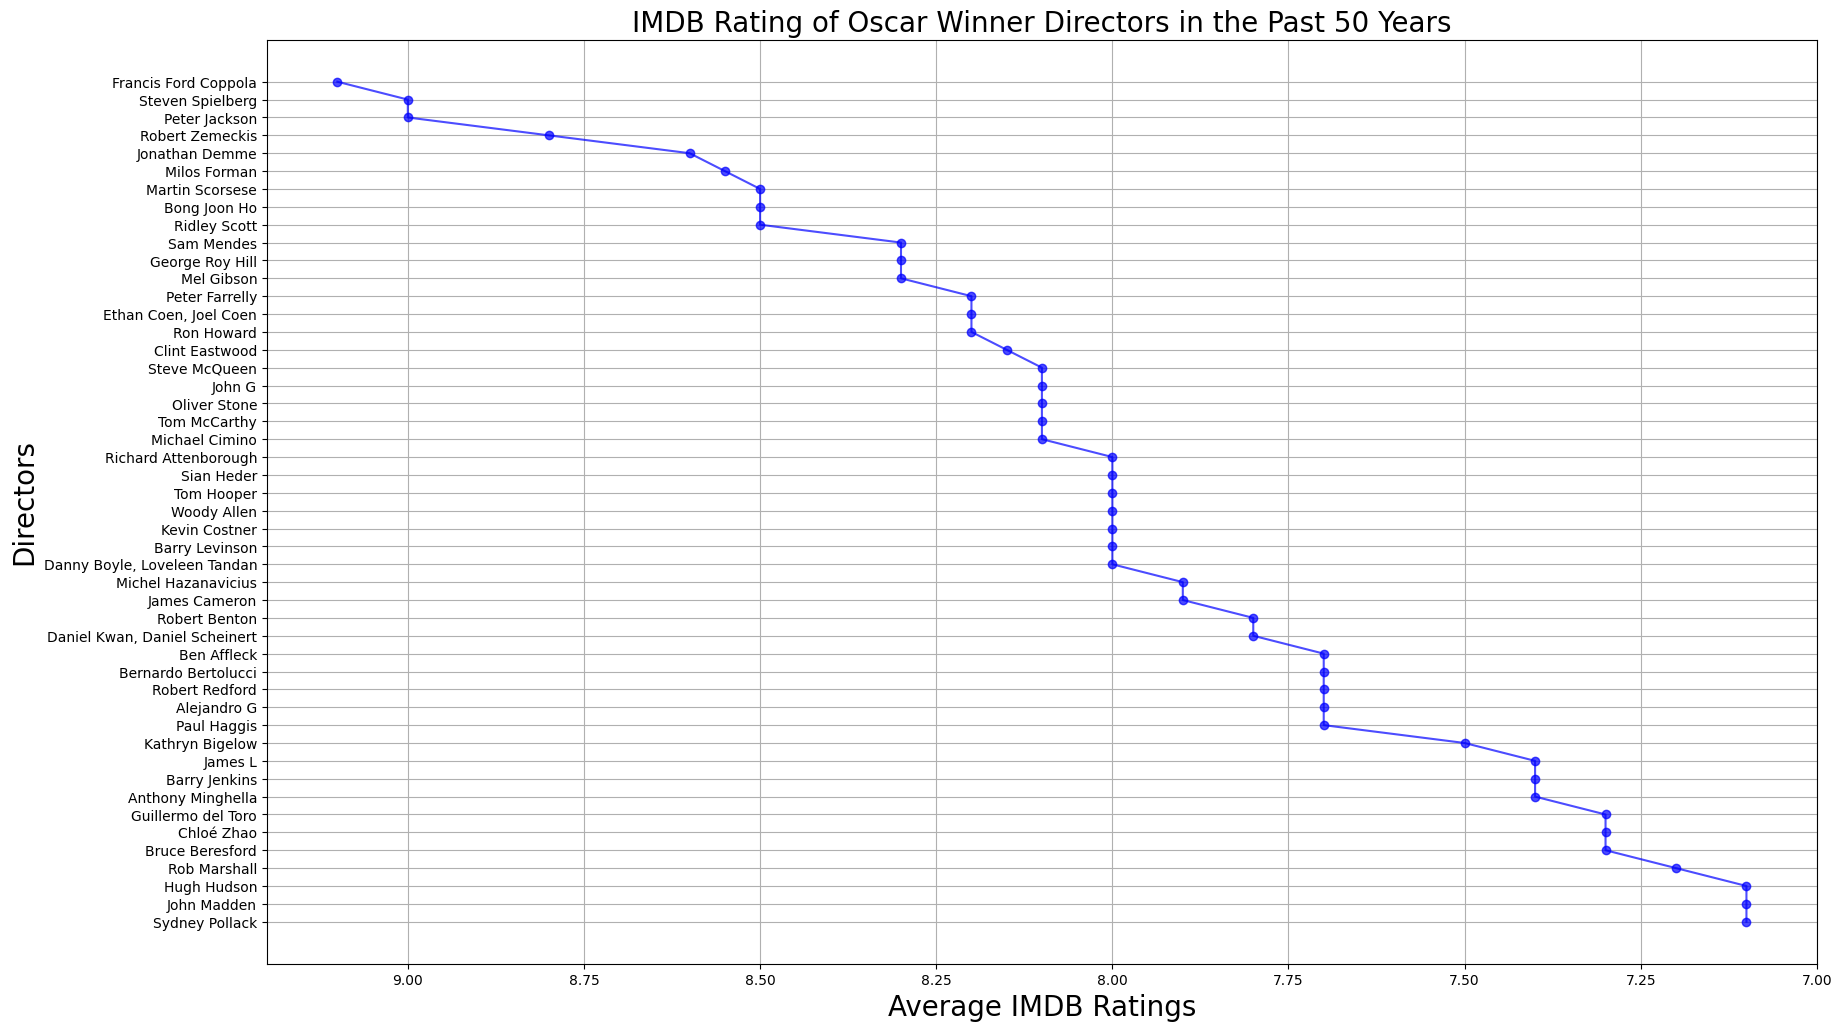

In [194]:
plt.figure(figsize=(20, 12))

plt.plot(director_df['Rating'], director_df['Director'], marker='o', linestyle='-', color='blue', alpha=0.7, label='Winner Directors')
plt.grid()
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()


plt.xlabel('Average IMDB Ratings', fontsize = 20)
plt.ylabel('Directors', fontsize = 20)
plt.title('IMDB Rating of Oscar Winner Directors in the Past 50 Years', fontsize = 20)

# Save it
plt.savefig('average_ratings_by_director.png')

plt.show();

## 2.3. Ratings of Nominees

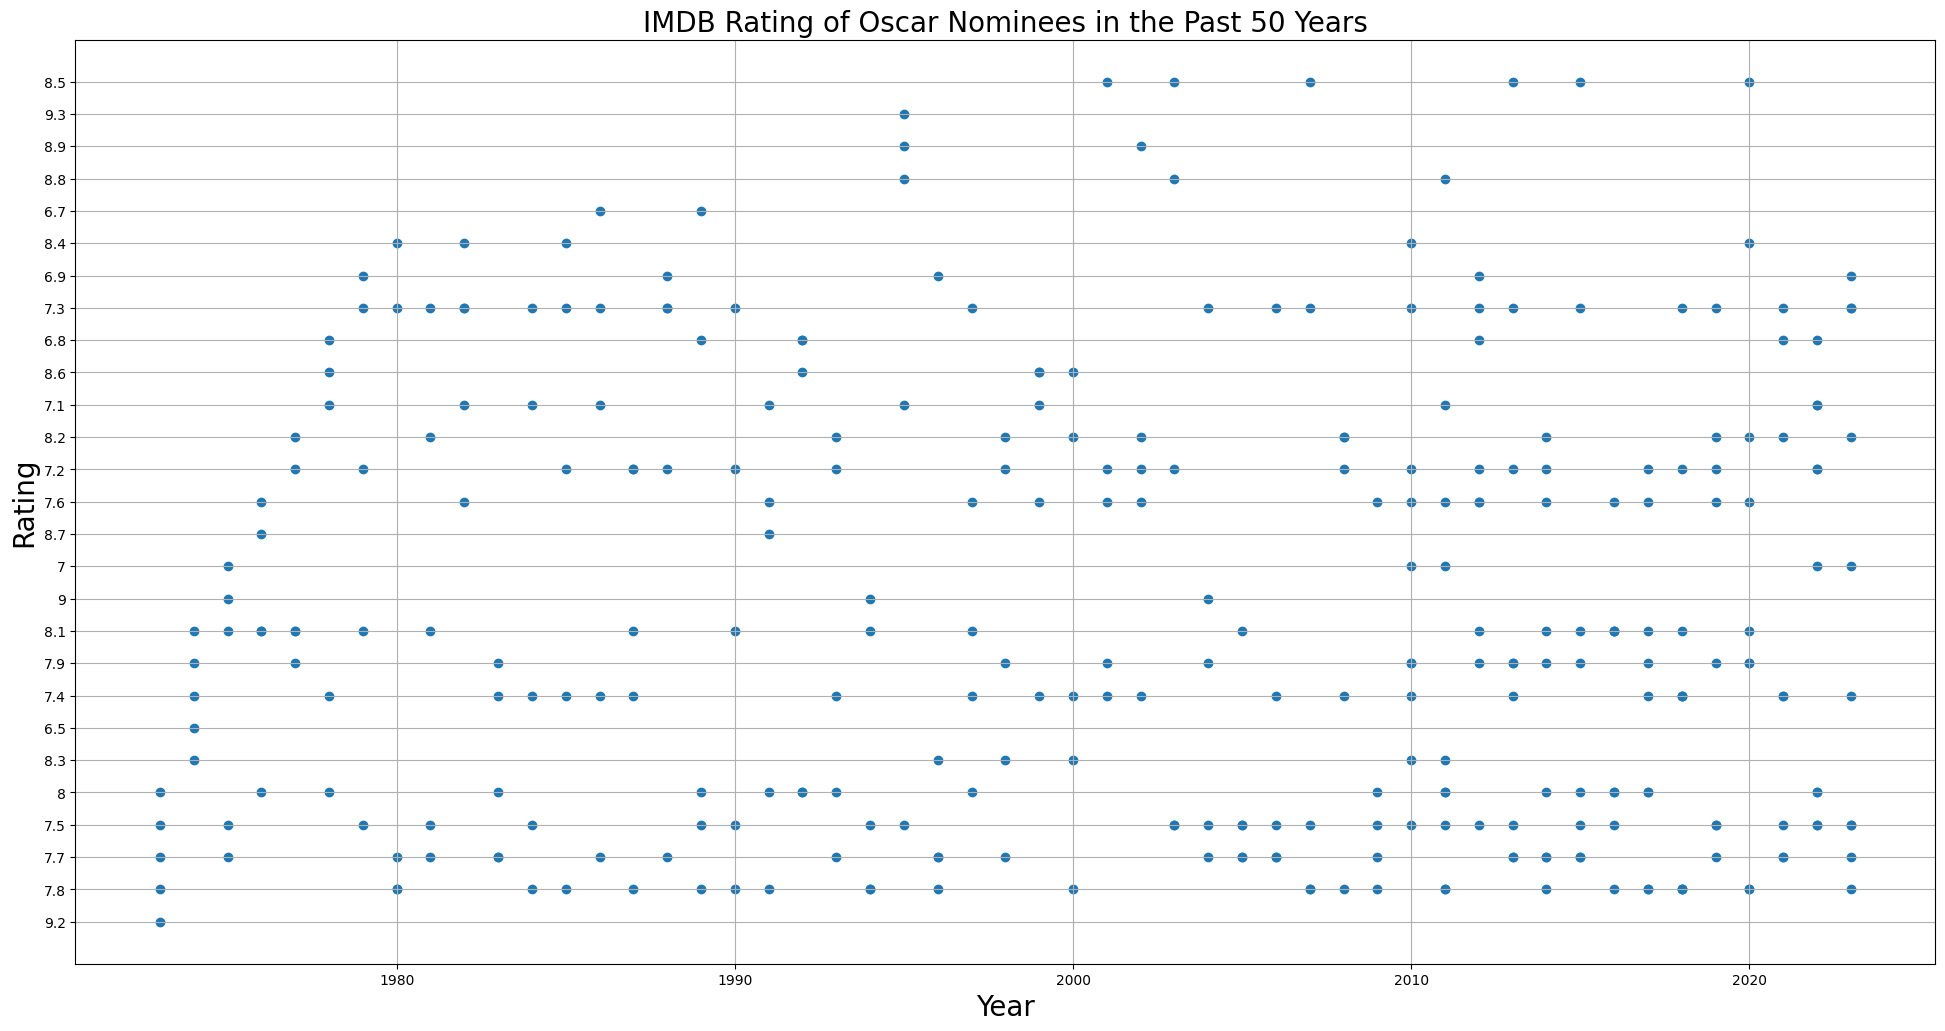

In [213]:
# Extracting the data
x = df['Year']
y = df['Rating']
z = df['primaryNominees_name']

# Create the plot with specified size
plt.figure(figsize=(24, 12))  # Set a larger figure size

# Plotting
plt.scatter(x, y)  # Increase marker size and line width

# Set axis labels with more reasonable font sizes
plt.xlabel('Year', fontsize=20)
plt.ylabel('Rating', fontsize=20)
plt.title('IMDB Rating of Oscar Nominees in the Past 50 Years', fontsize = 20)


# Save the plot
plt.savefig('average_ratings_by_nominee_movie.png')
plt.grid()
# Show the plot
plt.show()


# 3. Linear Regression

## 3.1. Based on Year

### 3.1.1. Split the Data

In [2]:
df = pd.read_json('1973-2023.json')

In [3]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [4]:
train_df.shape

(248, 5)

In [5]:
Year = ['Year']
X_train = train_df[Year]
X_train.shape

(248, 1)

In [6]:
target = 'Rating'
y_train = train_df[target]

In [21]:
X_test = test_df[Year]
X_test.shape

(63, 1)

In [24]:
y_test = test_df[target]

### 3.1.2. Baseline Model

In [7]:
y_train = y_train.astype(float)
y_train

109    7.8
247    8.0
234    7.9
202    8.3
78     7.3
      ... 
188    7.9
71     7.2
106    8.1
270    7.9
102    7.4
Name: Rating, Length: 248, dtype: float64

In [8]:
y_mean = y_train.mean()
y_mean

np.float64(7.695564516129032)

In [9]:
# Rudmientary way to create training data by using the same mean for every entry
y_pred_baseline = [y_mean] * len(y_train)
y_pred_baseline[:5]

[np.float64(7.695564516129032),
 np.float64(7.695564516129032),
 np.float64(7.695564516129032),
 np.float64(7.695564516129032),
 np.float64(7.695564516129032)]

In [10]:
mae_baseline = mean_absolute_error(y_pred_baseline, y_train)

print("Mean IMDB Rating Score: ", y_mean)
print("Baseline MAE (Mean Absolute Error):" , mae_baseline)

Mean IMDB Rating Score:  7.695564516129032
Baseline MAE (Mean Absolute Error): 0.36916623309053065


In [11]:
mse_baseline = mean_squared_error(y_pred_baseline , y_train)

print("Mean IMDB Rating Score: ", y_mean)
print("Baseline MSE (Mean Square Error):" , mse_baseline)

Mean IMDB Rating Score:  7.695564516129032
Baseline MSE (Mean Square Error): 0.2181658103537981


### 3.1.3. Linear Regression Model

In [12]:
model = LinearRegression()

In [13]:
assert isinstance(model, LinearRegression)

In [14]:
model.fit(X_train, y_train)

LinearRegression()

In [15]:
X_train

,Year
109,1994
247,2016
234,2015
202,2011
78,1988
...,...
188,2010
71,1987
106,1994
270,2019


In [16]:
y_train

109    7.8
247    8.0
234    7.9
202    8.3
78     7.3
      ... 
188    7.9
71     7.2
106    8.1
270    7.9
102    7.4
Name: Rating, Length: 248, dtype: float64

### 3.1.4. Predict

In [17]:
y_pred_training = model.predict(X_train)
y_pred_training[:5]

array([7.70766362, 7.6723627 , 7.67396729, 7.68038564, 7.71729115])

In [18]:
mae_training = mean_absolute_error(y_train, y_pred_training)

print("Training MAE (Mean Absolute Error):" , mae_training)

Training MAE (Mean Absolute Error): 0.3700687190081813


In [22]:
y_pred_test = model.predict(X_test)


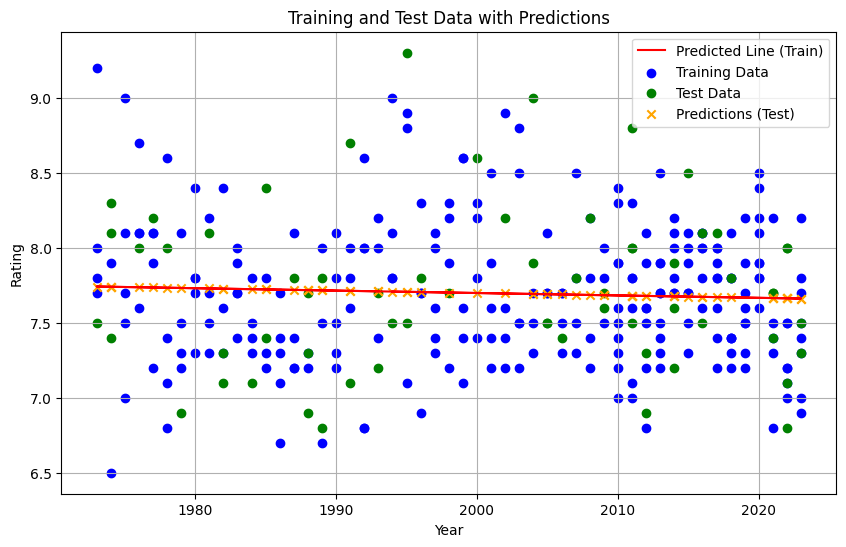

In [25]:
# Generate predictions for training data
y_pred_train = model.predict(X_train)

# Generate predictions for test data
y_pred_test = model.predict(X_test)

# Plotting training data and predictions
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(X_train, y_pred_train, color='red', label='Predicted Line (Train)')
plt.scatter(X_train, y_train, color='blue', label='Training Data')

# Plotting test data and predictions
plt.scatter(X_test, y_test, color='green', label='Test Data', marker='o')
plt.scatter(X_test, y_pred_test, color='orange', label='Predictions (Test)', marker='x')

plt.title('Training and Test Data with Predictions')
plt.xlabel('Year')
plt.ylabel('Rating')
plt.legend()
plt.grid()
plt.savefig('linear-regression-rating-by-year.png')
plt.show()


In [348]:
mae = mean_absolute_error(y_test, y_pred_test)
mae

np.float64(0.4138133734821072)

In [349]:
year_2030 = np.array([[2030]])  # Reshape for a single sample
prediction_2030 = model.predict(year_2030)
prediction_2030

/Users/nshafiei/.local/share/mise/installs/python/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([7.64989848])

## 3.2. Based on Director

In [55]:
df = pd.read_json('1973-2023.json')

In [56]:
df.head()

,primaryNominees_name,isWinner,Year,Director,Rating
0,The Godfather,True,1973,Francis Ford Coppola,9.2
1,Cabaret,False,1973,Bob Fosse,7.8
2,Deliverance,False,1973,John Boorman,7.7
3,Sounder,False,1973,Martin Ritt,7.5
4,The Emigrants,False,1973,Jan Troell,8.0


In [57]:
df['Director'].unique().shape

(196,)

In [58]:
director_df_nominee = df.groupby('Director').agg(
    Average_Rating=('Rating', 'mean'),
    Movie_Count=('Rating', 'count')
).reset_index()

director_df_nominee = director_df_nominee.sort_values(by='Average_Rating', ascending=False)
director_df_nominee.head()

,Director,Average_Rating,Movie_Count
50,Frank Darabont,8.95,2
139,Peter Jackson,8.90,3
155,Robert Zemeckis,8.80,1
156,Roberto Benigni,8.60,1
89,Jonathan Demme,8.60,1


In [59]:
director_df_nominee = director_df_nominee.sort_values(by='Movie_Count', ascending=False)
director_df_nominee

,Director,Average_Rating,Movie_Count
178,Steven Spielberg,7.776923,13
112,Martin Scorsese,8.000000,9
29,Clint Eastwood,7.860000,5
49,Francis Ford Coppola,8.380000,5
9,Ang Lee,7.800000,4
...,...,...,...
94,Kenneth Lonergan,7.800000,1
90,Jordan Peele,7.800000,1
88,"Jonathan Dayton, Valerie Faris",7.800000,1
33,"Daniel Kwan, Daniel Scheinert",7.800000,1


### 3.2.1. K-means clustering

#### 3.2.1.1. Clustering Features

In [60]:
# Select the features for clustering

X = director_df_nominee[["Average_Rating", "Movie_Count"]]

In [61]:
# Scale the Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


#### 3.2.1.2. Elbow Method

In [79]:
# Use the elbow method to find the optimal number of clusters
wcss = []
range_n_clusters = range(1, 11)  # Adjust the range as needed

for i in range_n_clusters:
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # WCSS is stored in inertia_

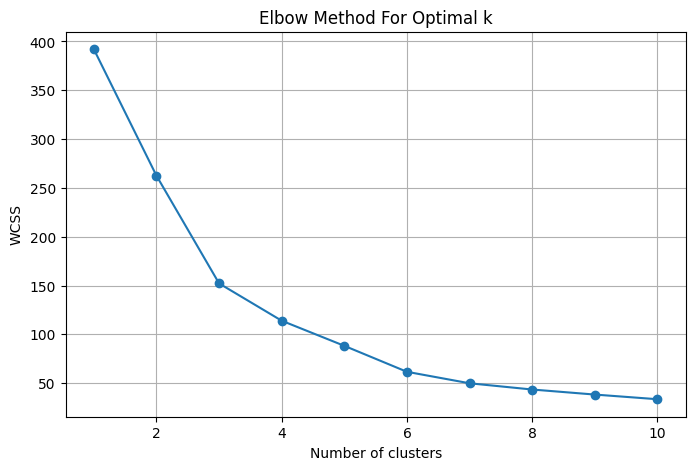

In [96]:
# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid()
plt.savefig('elbow-method.png')

plt.show()

#### 3.2.1.3. Silhouette Method

Silhouette Score for 2 clusters: 0.407
Silhouette Score for 3 clusters: 0.437
Silhouette Score for 4 clusters: 0.485
Silhouette Score for 5 clusters: 0.427
Silhouette Score for 6 clusters: 0.416
Silhouette Score for 7 clusters: 0.456


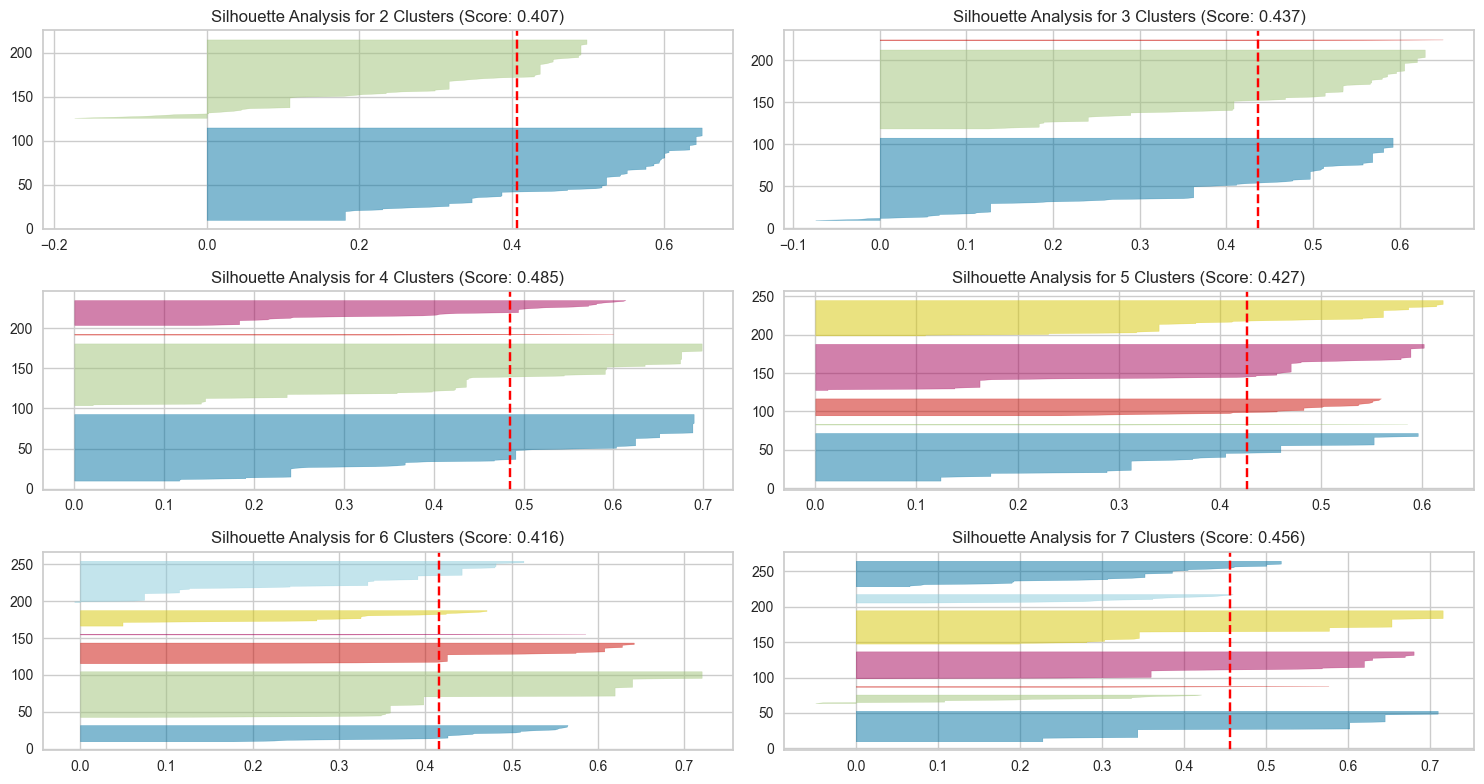

In [78]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer

range_n_clusters = range(2, 8)  # Adjusted to match your for loop
fig, ax = plt.subplots(3, 2, figsize=(15, 8))

for i in range_n_clusters:
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    
    # Fit the model
    km.fit(X_scaled)
    
    # Calculate silhouette score
    score = silhouette_score(X_scaled, km.labels_)
    print(f'Silhouette Score for {i} clusters: {score:.3f}')
    
    q, mod = divmod(i - 2, 2)  # Adjust for 0-based indexing in subplots
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q][mod])
    visualizer.fit(X_scaled)
    
    # Label the subplot
    ax[q][mod].set_title(f'Silhouette Analysis for {i} Clusters (Score: {score:.3f})')

#plt.savefig('silhouette-method.png', bbox_inches='tight')

plt.tight_layout()
plt.savefig('silhouette-method.png', bbox_inches='tight', dpi=300)

plt.show()


### 3.2.2. 3 Clusters

In [81]:
# Trying with 3 
k = 3  
kmeans = KMeans(n_clusters=k, random_state=42)
director_df_nominee['Cluster'] = kmeans.fit_predict(X_scaled)


In [82]:
# Group by cluster and list the directors
clustered_directors = director_df_nominee.groupby('Cluster')['Director'].apply(list).reset_index()

print(clustered_directors)


   Cluster                                           Director
0        0  [James Ivory, Stephen Frears, James L, Bob Fos...
1        1  [Clint Eastwood, Francis Ford Coppola, Ang Lee...
2        2                [Steven Spielberg, Martin Scorsese]


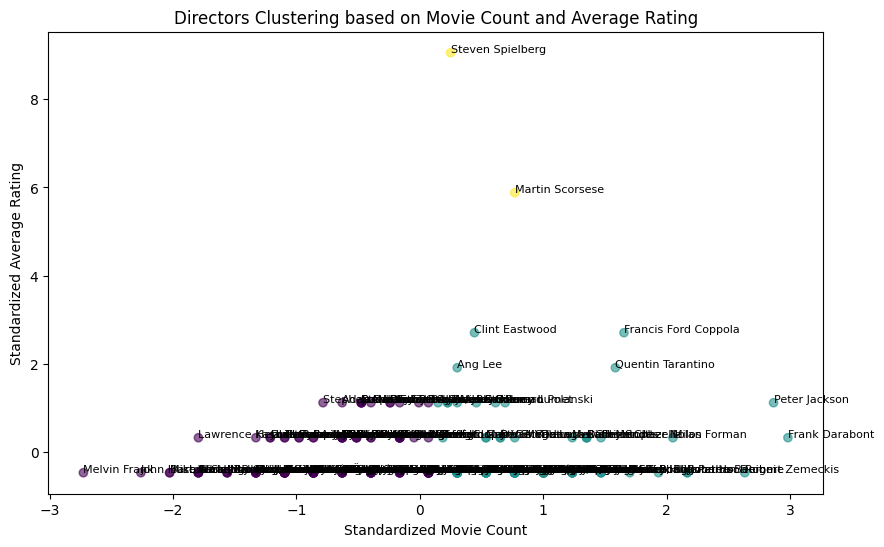

In [83]:
plt.figure(figsize=(10, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=director_df_nominee['Cluster'], cmap='viridis', alpha=0.6)
plt.title('Directors Clustering based on Movie Count and Average Rating')
plt.xlabel('Standardized Movie Count')
plt.ylabel('Standardized Average Rating')

# Annotate points with director names
for i, director in enumerate(director_df_nominee['Director']):
    plt.annotate(director, (X_scaled[i, 0], X_scaled[i, 1]), fontsize=8)

plt.show()


In [84]:
#  Filter directors with Movie_Count greater than 2
directors_count_gt_2 = director_df_nominee[director_df_nominee['Movie_Count'] > 2]

# Step 2: Create a summary for clusters
cluster_summary = director_df_nominee.groupby('Cluster').agg(
    Director_Count=('Director', 'count'),
    Director_Names=('Director', lambda x: ', '.join(x[x.index.isin(directors_count_gt_2.index)]))
).reset_index()


[[-0.08006655  0.1889914 ]
 [ 1.13142807 -0.21833492]
 [ 0.50933492  7.46657663]
 [-1.20057469 -0.31573651]]


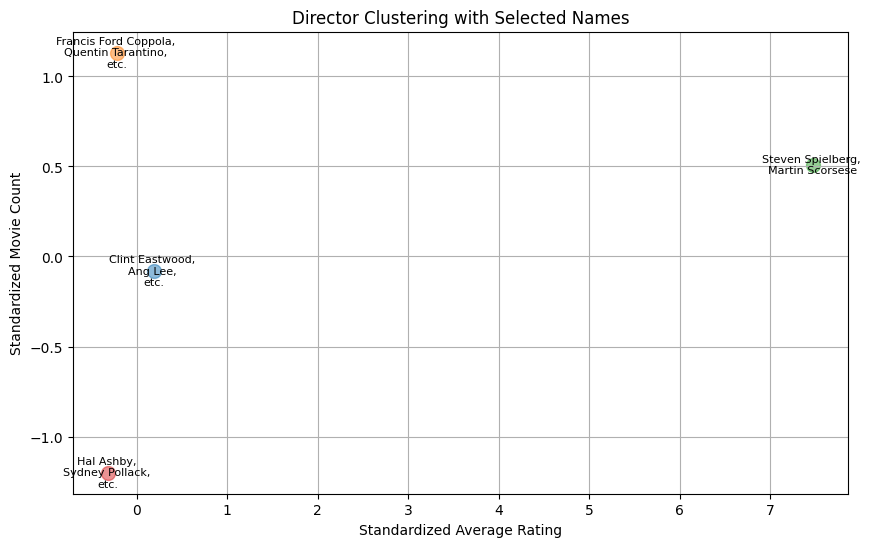

In [98]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Assuming `clustered_directors` is a DataFrame with the cluster information
# and you have cluster centers already defined.

# Create a scatter plot for cluster centers
plt.figure(figsize=(10, 6))

# Get the cluster centers
centers = kmeans.cluster_centers_  # Assuming kmeans is already fitted
print(centers)
# Plot circles for each cluster center
for i in range(len(centers)):
    plt.scatter(centers[i, 1], centers[i, 0], s=100, alpha=0.5)  # Adjust size as needed

    # Retrieve the names for the current cluster
    director_names = clustered_directors['Director'][i]
    if len(director_names) > 2:
        displayed_names = f"{director_names[0]}, \n{director_names[1]}, \netc."
    else:
        displayed_names = ', \n'.join(director_names)

    # Annotate with the names
    plt.annotate(displayed_names, (centers[i, 1], centers[i, 0]), fontsize=8, ha='center', va='center')

plt.title('Director Clustering with Selected Names')
plt.xlabel('Standardized Average Rating')  # x-axis
plt.ylabel('Standardized Movie Count')      # y-axis
plt.savefig('3-k-means-clustering.png')

plt.grid()
plt.show()


### 3.2.3. 4 Clusters

In [86]:
# trying with 4
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
director_df_nominee['Cluster'] = kmeans.fit_predict(X_scaled)


In [87]:
clustered_directors = director_df_nominee.groupby('Cluster')['Director'].apply(list).reset_index()

print(clustered_directors)

   Cluster                                           Director
0        0  [Clint Eastwood, Ang Lee, James Ivory, Alejand...
1        1  [Francis Ford Coppola, Quentin Tarantino, Pete...
2        2                [Steven Spielberg, Martin Scorsese]
3        3  [Hal Ashby, Sydney Pollack, Bruce Beresford, L...


[[-0.08006655  0.1889914 ]
 [ 1.13142807 -0.21833492]
 [ 0.50933492  7.46657663]
 [-1.20057469 -0.31573651]]


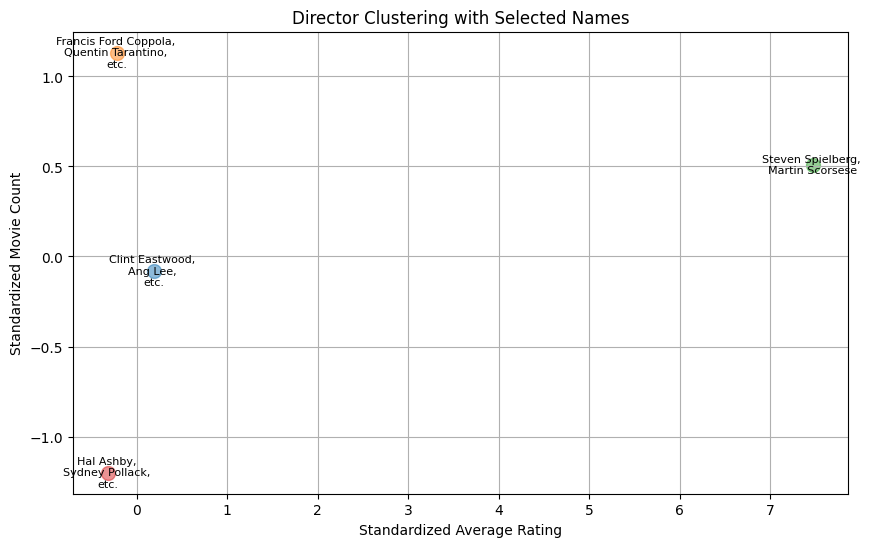

In [88]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Assuming `clustered_directors` is a DataFrame with the cluster information
# and you have cluster centers already defined.

# Create a scatter plot for cluster centers
plt.figure(figsize=(10, 6))

# Get the cluster centers
centers = kmeans.cluster_centers_  # Assuming kmeans is already fitted
print(centers)
# Plot circles for each cluster center
for i in range(len(centers)):
    plt.scatter(centers[i, 1], centers[i, 0], s=100, alpha=0.5)  # Adjust size as needed

    # Retrieve the names for the current cluster
    director_names = clustered_directors['Director'][i]
    if len(director_names) > 2:
        displayed_names = f"{director_names[0]}, \n{director_names[1]}, \netc."
    else:
        displayed_names = ', \n'.join(director_names)

    # Annotate with the names
    plt.annotate(displayed_names, (centers[i, 1], centers[i, 0]), fontsize=8, ha='center', va='center')

plt.title('Director Clustering with Selected Names')
plt.xlabel('Standardized Average Rating')  # x-axis
plt.ylabel('Standardized Movie Count')      # y-axis
plt.savefig('4-k-means-clustering.png')

plt.grid()
plt.show()


-----